In [1]:
import numpy as np
import os
import sys
from pprint import pprint
from numpy import sin, cos, pi
import numpy.matlib
import random
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, Point
import shapely.affinity as affinity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
import pyomo.environ as pyo
import pyomo.gdp as pyg
from scipy.spatial import ConvexHull
#tf.disable_v2_behavior()  # this line is added to allow placeholder() function to work (does not work in tf2)

2022-02-12 04:53:45.011112: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/daittan/catkin_ws/devel/lib:/opt/ros/melodic/lib:/home/daittan/NN-Repair/gurobi912/linux64/lib
2022-02-12 04:53:45.011143: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Introduction

In this code, we generate a neural network that predicts the transformed (rotated) value of the input point.

We then enforce a constraint on the output set such that we require the transformed (rotated) points to stay within a certain box. These constraints can be defined in the form of $Ax < b$. 

The idea is to repair the layers of the original neural network train in order to ensure the following two cases:

1) If true transformed (rotated) points are following the constraint, the predicted transformed (rotated) points are close to the true transformed (rotated) points as well as follow the constraint; and


2) If true transformed (rotated) points are violating the constraint, the predicted transformed (rotated) points are close to the true transformed (rotated) points but also follow the constraint.
-----------------


#  Creating Original Neural Network 

## Create Data 

Here, we start by defining the number of points and the polygon.

In [2]:
num_pts = 200
## polygon vertices
poly = Polygon([(1, 1), (4, 1), (4, 4), (1, 4)])
poly2 = Polygon([(2.5, 4.621), (4.624, 2.5), (2.5, 0.3787), (0.3787, 2.5)])  # transformed polygon vertices
x_poly, y_poly = poly.exterior.xy
x_poly2, y_poly2 = poly2.exterior.xy

Plotting the Original polygon and the polygon after rotating it.

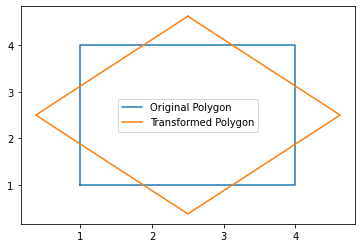

In [3]:
plt.plot(x_poly,y_poly, label = "Original Polygon")
plt.plot(x_poly2, y_poly2, label = "Transformed Polygon")
plt.legend()
plt.show()

Generation of Random Points within the bounds in order to create a training dataset

In [4]:

def random_points_within(pol, num_points):
    min_x, min_y, max_x, max_y = pol.bounds

    gen_points = []

    while len(gen_points) < num_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        if random_point.within(pol):
            gen_points.append(random_point)

    return gen_points

points_obj = random_points_within(poly, num_pts)
x = np.ones((3, num_pts))     #(x,y,b)

for i in range(num_pts):
    x[0][i] = points_obj[i].x
    x[1][i] = points_obj[i].y


Note that here, we have $x$ which are samples from the original polygon and we predict $y$ which are the transformed input samples. Given this, we want to generate a neural network that can tranform an original point from the original polygon and predict its transformed value.

In [10]:
## rotate input points in-place by pi/4 radian
transform1 = np.array([[1, 0, 2.5], [0, 1, 2.5], [0, 0, 1]])  # transformation matrix 1
transform2 = np.array([[1, 0, -2.5], [0, 1, -2.5], [0, 0, 1]])  # transformation matrix 2
rotate = np.array([[cos(pi / 4), -sin(pi / 4), 0], [sin(pi / 4), cos(pi / 4), 0], [0, 0, 1]])  # rotation matrix
y = np.matmul(np.matmul(np.matmul(transform1, rotate), transform2), x)

## Generating of Safe Bound

In [11]:
inp = np.array([[1.25, 3.75, 3.75, 1.25],[1.25, 1.25, 3.75, 3.75],[1, 1 , 1, 1]])
out = np.matmul(np.matmul(np.matmul(transform1, rotate), transform2), inp)
poly3 = Polygon([(out[0, 0], out[1, 0]), (out[0, 1], out[1, 1]), (out[0, 2], out[1, 2]), (out[0, 3], out[1, 3])])

# get the coordinates of the exterior points of the polytope
ex_points = np.array(poly3.exterior.coords)

# get A and b matrices
hull = ConvexHull(ex_points)
eqs = np.array(hull.equations)
A = eqs[0:eqs.shape[0],0:eqs.shape[1]-1]
b = -eqs[0:eqs.shape[0],-1]


### Plot the Genarated Data 
 Here, we display the plots tht can give a quick summary of the input set, output set and the constraint.

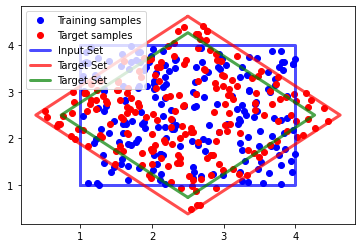

In [12]:
## plot generated data
x_poly3, y_poly3 = poly3.exterior.xy
plt.plot(x[0, :], x[1, :], 'bo', label='Training samples')
plt.plot(y[0, :], y[1, :], 'ro', label='Target samples')
plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Input Set')
plt.plot(x_poly2, y_poly2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.plot(x_poly3, y_poly3, color='green', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.legend(loc="upper left")
plt.show()

x = np.transpose(x)
y = np.transpose(y)

### Generate data points around the edge

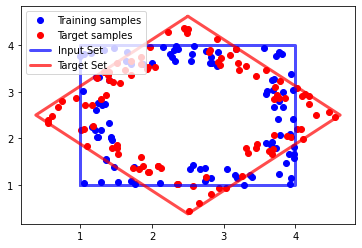

In [13]:
def random_points_edge(poly, num_points, scale = 0.7):
    poly_a = affinity.scale(poly, xfact = scale, yfact = scale)
    gen_points = []
    while len(gen_points) < num_points:
        temp = random_points_within(poly, 1)
        if not temp[0].within(poly_a):
            gen_points.append(temp[0])
    return gen_points

num_points_edge = 100
points_edge = random_points_edge(poly, num_points_edge)
x_edge = np.ones((3, num_points_edge))     #(x,y,b)

for i in range(num_points_edge):
    x_edge[0][i] = points_edge[i].x
    x_edge[1][i] = points_edge[i].y

## rotate input points in-place by pi/4 radian
y_edge = np.matmul(np.matmul(np.matmul(transform1, rotate), transform2), x_edge)
    
## plot generated data
plt.plot(x_edge[0, :], x_edge[1, :], 'bo', label='Training samples')
plt.plot(y_edge[0, :], y_edge[1, :], 'ro', label='Target samples')
plt.plot(x_poly, y_poly, color='blue', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Input Set')
plt.plot(x_poly2, y_poly2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2, label='Target Set')
plt.legend(loc="upper left")
plt.show()
x_edge = np.transpose(x_edge)
y_edge = np.transpose(y_edge)

In [14]:
x = np.append(x, x_edge,axis = 0)
y = np.append(y, y_edge,axis = 0)

## Training Mini-Batch Generator



In [15]:
class Batch(object):
    def __init__(self, X_col, Y_col, batch_size_val):
        self.X = X_col
        self.Y = Y_col
        self.size = X_col.shape[0]
        self.train_size = batch_size_val
        self.test_size = self.size - batch_size_val

    def getBatch(self):
        values = range(self.size)
        train_dataset, test_dataset = train_test_split(values, train_size=self.train_size, test_size=self.test_size)
        # indices = np.random.choice(range(self.size), self.batch_size)  # sampling with replacement
        return self.X[train_dataset, :], self.Y[train_dataset, :], self.X[test_dataset, :], self.Y[test_dataset, :]


In [16]:
num_pts = x.shape[0]
batch_size = int(0.7 * num_pts)
batch = Batch(x, y, batch_size)
x_train, y_train, x_test, y_test = batch.getBatch()

-----------------------
# 3-Layer NN

## Build 3-Layer NN Model

Here we setup a 3-layer MLP, with the single hidden layer of ReLU activation and train it with gradient descent optimizer to learn the defined affine transformation from the given data. 
$$
\min_{\mathbf{W}^0,\mathbf{W}^1,\mathbf{W}^2,\mathbf{b}^0,\mathbf{b}^1,\mathbf{b}^2}~~\frac{1}{2}\sum^{N}_{n=1}|| \mathbf{y}(\mathbf{x}^0_n,\mathbf{W}^0,\mathbf{W}^1,\mathbf{b}^0,\mathbf{b}^1)-\mathbf{t}_n||^2_2
$$
$$
\mathbf{W}^0 \mathbf{x}^0 + \mathbf{b}^0 = \mathbf{h}^0
$$
$$
\mathbf{x}^1 = \mathrm{ReLU} (\mathbf{h}^0)
$$
$$
\mathbf{W}^1 \mathbf{x}^1 + \mathbf{b}^1 = \mathbf{h}^1
$$
$$
\mathbf{x}^2 = \mathrm{ReLU} (\mathbf{h}^1)
$$
$$
\mathbf{W}^2 \mathbf{x}^2 + \mathbf{b}^2 = \mathbf{y}
$$

![NN_original.jpg](NN_original.jpg)


#### Initializing Parameters for MLP Model

In [17]:
num_input = batch.X.shape[1]
num_output = batch.Y.shape[1]
num_hidden_0 = 20
num_hidden_1 = 10
architecture = [num_input, num_hidden_0, num_hidden_1, num_output]

starter_learning_rate = 0.01
regularizer_rate = 0.001

#Create the 3 layers model
# Define Sequential model with 3 layers
model_orig = keras.Sequential(name="3_layer_NN")
model_orig.add(layers.Dense(num_hidden_0,
                            activation="relu",
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate),
                            input_shape=(3,),
                            name="layer0"))
#model_orig.add(layers.Dropout(0.01))
model_orig.add(layers.Dense(num_hidden_1,
                            activation="relu",
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate),
                            name="layer1"))
#model_orig.add(layers.Dropout(0.01))
model_orig.add(layers.Dense(num_output,
                            kernel_regularizer = regularizers.l2(regularizer_rate),
                            bias_regularizer = regularizers.l2(regularizer_rate), 
                            name="output"))

model_orig.summary()

Model: "3_layer_NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer0 (Dense)               (None, 20)                80        
_________________________________________________________________
layer1 (Dense)               (None, 10)                210       
_________________________________________________________________
output (Dense)               (None, 3)                 33        
Total params: 323
Trainable params: 323
Non-trainable params: 0
_________________________________________________________________


2022-02-12 04:31:17.332495: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-12 04:31:17.332929: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/daittan/catkin_ws/devel/lib:/opt/ros/melodic/lib:/home/daittan/NN-Repair/gurobi912/linux64/lib
2022-02-12 04:31:17.333049: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/daittan/catkin_ws/devel/lib:/opt/ros/melodic/lib:/home/daittan/NN-Repair/gurobi912/linux64/lib
2022-02-12 04:31:17.333149: W tensorflow/stream_executor/platform/default/dso_loader.c

## Train the model

In [18]:
# define loss 
loss = keras.losses.MeanSquaredError(name='MSE')
#loss = keras.losses.MeanSquaredLogarithmicError(name='MSLE')
optimizer = keras.optimizers.SGD(learning_rate = starter_learning_rate, name='SGD')
model_orig.compile(optimizer = optimizer,
                   loss = loss,
                   metrics=['accuracy'])

In [19]:
his = model_orig.fit(x_train, y_train, epochs=300, use_multiprocessing = True, verbose = 0)
print("Model Accuracy on Test Data Set")
model_orig.evaluate(x_test,  y_test, verbose=2)


2022-02-12 04:31:17.768170: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Model Accuracy on Test Data Set
3/3 - 0s - loss: 0.0265 - accuracy: 1.0000


[0.026539204642176628, 1.0]

## Plot Loss Function

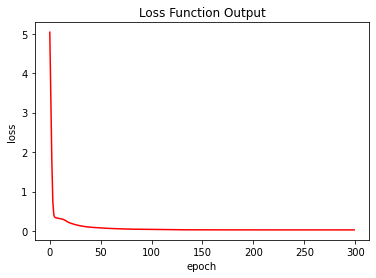

In [20]:

results_train_loss = his.history['loss']
plt.plot(results_train_loss, color='red')
plt.title('Loss Function Output')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

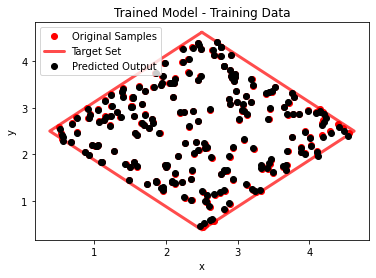

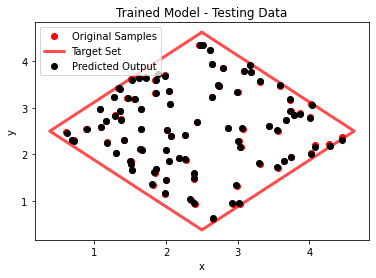

In [21]:
#### Plot Trained Model Ouput
def plot_model(model, x_true, y_true, poly_1, poly_2, arg):
    y_predict = model_orig.predict(x_true)
    
    ## training output
    plt.plot(y_true[:, 0], y_true[:, 1], 'ro', label='Original Samples')
    x_poly_2, y_poly_2 = poly_2.exterior.xy
    plt.plot(x_poly_2, y_poly_2, color='red', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2,
             label='Target Set')

    ## predicted output
    plt.plot(y_predict[:, 0], y_predict[:, 1], 'ko', label='Predicted Output')
    plt.title(arg)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend(loc="upper left")
    plt.show()
    return y_predict

y_predict_train = plot_model(model_orig, x_train, y_train, poly, poly2, arg='Trained Model - Training Data')
y_predict_test = plot_model(model_orig, x_test, y_test, poly, poly2, arg='Trained Model - Testing Data')


-------------------
# Saving Original Model and Datasets

In [23]:
import os

print(os.getcwd())
model_orig.save('affine_transform_original_model', os.getcwd())
import pickle

with open(os.getcwd() + "/affine_io_dataset.pickle", "wb") as data:
    pickle.dump([x_train, y_train, x_test, y_test], data)

/home/daittan/NNRepLayer/test_nnreplayer/test_nnreplayer
INFO:tensorflow:Assets written to: affine_transform_original_model/assets
